# Search, analysis and visualization of the selected compounds

This code searches a .csv table provided by ENAMINE for a compound(s) of interest and then visualizes it. Optionally, one can visually inspect structural differences of 2 compounds, which are going to be highlighted. 

## What is required for code execution: 

- conda installed on your machine: https://www.anaconda.com/download/
- once conda is installed, some important packages should be installed as well: (add github file .yml)

## Once it's all done, you can execute the code (Shift+Enter)

The following chunk of code will import all the needed packages to work with compounds: 

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.pyplot import cm
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole, rdDepictor
pd.set_option('display.max_colwidth', None)

## Defining the ENAMINE .csv table which contains compounds:

You need to put the path of the file to open like that: **'/.../filename.csv'**

In [24]:
screening_comps = pd.read_csv('/Users/ncyx/Desktop/Studium/Master/lab_rotations/Claudio/data_Pirh2/screening_Claudio/compounds_list_to_screen.csv',
                      sep=';')
screening_comps = screening_comps.drop(index=(83))

## Search and visualization of the compounds: 

Once the interactive window pops out, you simply provide 4-digit number of the compounds **without** '#' separated by a space:

E.g. 1177 3862 3007 9870

4 digits of the compound(s) of interest (sep by space): 1177 3862
should concentration be calculated? y/n: n


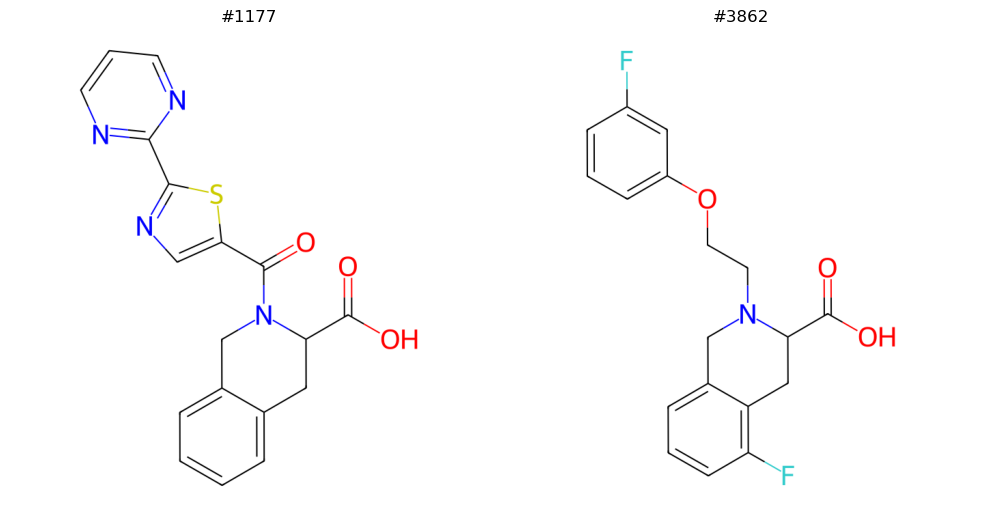

In [25]:
def search_and_analysis_comp(dataframe):
    
    '''
    
    Code for selecting a 4-digit number compounds from the .csv table and for its visualization. 
    As input you should provide 4-digit identified of the compound (e.g. 1177) separated by space. 
    If concentration should be calculated, type y in the second popping-out window. 
    If the wrong 4-digit identified is provided, prints an error "No matches found" -> check your input
    Returns a subset of the dataframe with compounds of interes, list of smiles and a list with compounds' names.  
    
    '''
    
    comp_identified = input('4 digits of the compound(s) of interest (sep by space): ')
    conc_condition = input('should concentration be calculated? y/n: ')
    comp_identified_list = comp_identified.split()
    smiles_list = []
    
    for i in range(len(comp_identified_list)):
        comp_of_interest = dataframe[dataframe['ID'].str.contains(comp_identified_list[i])]
        
        if len(comp_of_interest) == 0:
            raise Exception("No matches found!")

        if len(comp_of_interest) != 1:
            for j in comp_of_interest['ID']:
                if j[len(j)-4:] == comp_identified_list[i]:
                    comp_of_interest = comp_of_interest[comp_of_interest['ID'] == j]

        MW_comp = float(dataframe['MW'][comp_of_interest.index])
        mass_comp = float(dataframe['Amount_mg'][comp_of_interest.index])
        amount_comp = float(mass_comp/MW_comp)
        concentration_comp = (amount_comp / 100e-6)
        if conc_condition == 'y':
            print('compound',comp_identified_list[i], 'concentration: ', concentration_comp, 'mM')
            
        smiles_comp = dataframe['Smile'][comp_of_interest.index].to_string()
        IPythonConsole.drawOptions.addAtomIndices = False
        IPythonConsole.molSize = 400,400
        smiles_comp_corr = smiles_comp[5:]
        smiles_chem_mol = Chem.MolFromSmiles(smiles_comp_corr)
        smiles_list.append(smiles_chem_mol)
        
    def compounds_plot(smiles_list, names_list):
        
        '''
        
        Automatically generates a plot with the selected compounds. 
        As input takes a list of SMILES and 4-digit number of the corresponding compounds.
        Plots subplots: 2 rows and (number of compounds / 2) columns. If only 1 compounds is 
        provided, plots only 1 compound. 
        
        '''
        
        if len(smiles_list) > 2: 
            numb_cols = int(len(comp_identified_list))
            if len(smiles_list)%2 != 0:
                numb_cols = int(len(comp_identified_list)+1)
            fig, axs = plt.subplots(2, int(numb_cols/2), figsize=(10,8))
            i = 0
            for row in axs:
                for ax in row:
                    if i > (len(smiles_list)-1):
                        ax.plot()
                        ax.axis('off')
                    else:
                        ax.imshow(Chem.Draw.MolToImage(smiles_list[i],size=(700, 700)))
                        ax.set_title('#'+names_list[i])
                        ax.axis('off')
                        i += 1
        elif len(smiles_list) == 2 :
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,8))
            ax1.imshow(Chem.Draw.MolToImage(smiles_list[0],size=(700, 700)))
            ax1.axis('off')
            ax1.set_title('#'+names_list[0])
            ax2.imshow(Chem.Draw.MolToImage(smiles_list[1],size=(700, 700)))
            ax2.axis('off')
            ax2.set_title('#'+names_list[1])
        else:
            plt.imshow(Chem.Draw.MolToImage(smiles_list[0],size=(700, 700)))
            plt.title('#'+names_list[0])
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        plt.tight_layout()
        plt.show()
        
    compounds_plot(smiles_list, comp_identified_list)

    return comp_of_interest, smiles_list, comp_identified_list
dataframes,smiles,names_list = search_and_analysis_comp(screening_comps)

## This code highlights structural differences of  2 compounds:

- To execute this code, you first need to generate data by executing the first function. Once the compounds are defined, you can visualize their differences:  

which 2 molecules you want to compare?: 1177 3862


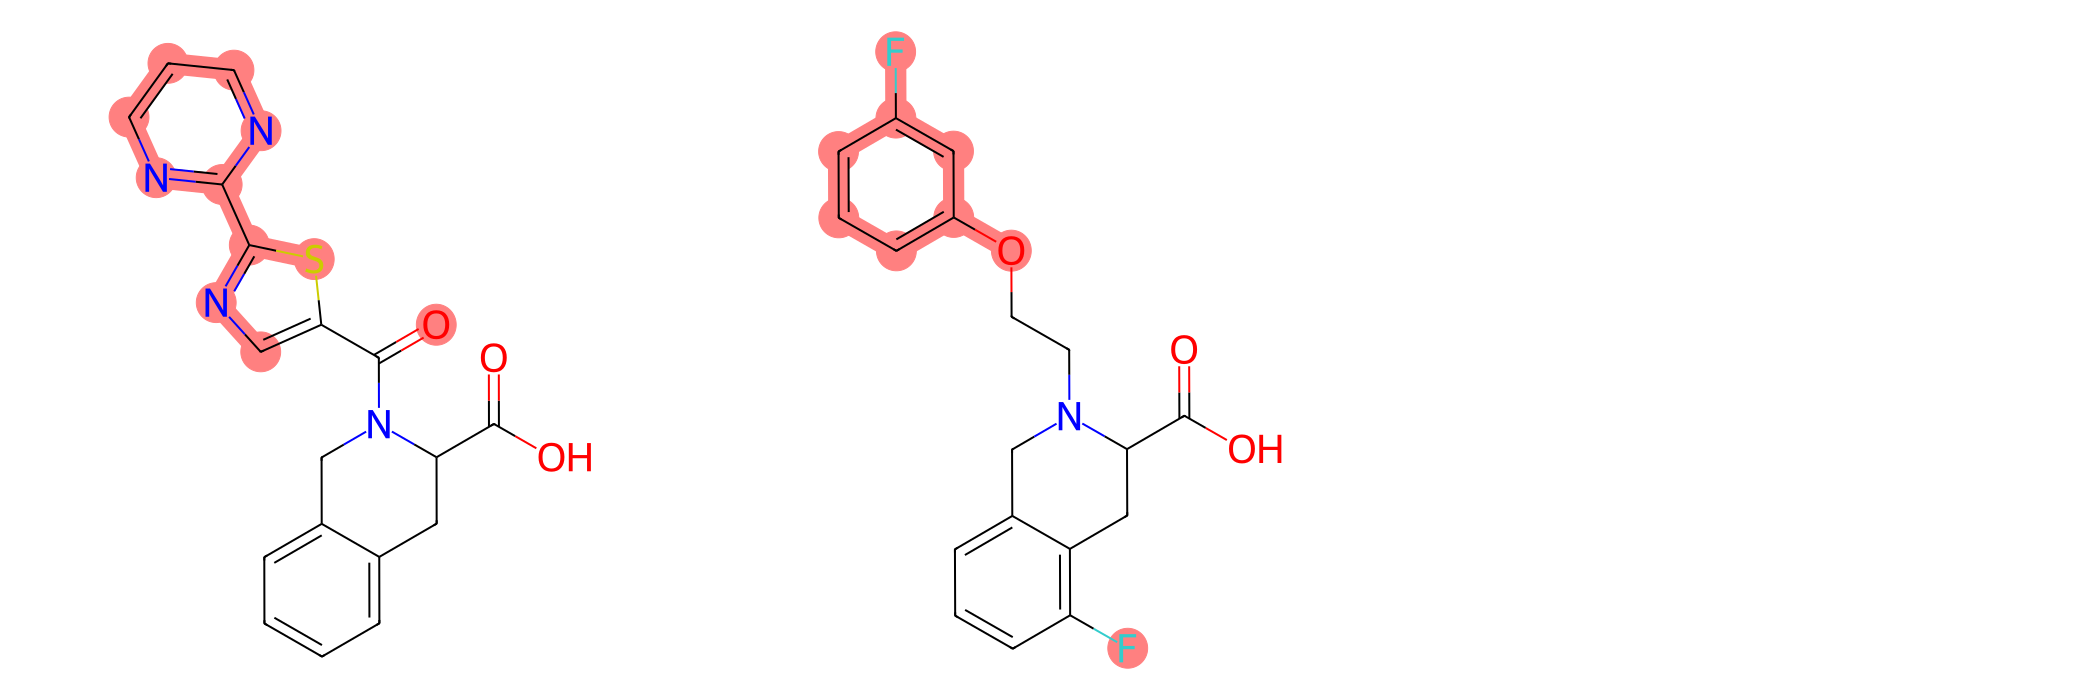

In [26]:
def view_difference(smiles_list, names_list):
    
    rdDepictor.SetPreferCoordGen(True)
    IPythonConsole.drawOptions.minFontSize=20
    which_compare = input('which 2 molecules you want to compare?: ')
    which_compare_list = which_compare.split()
    
    mol1 = smiles_list[names_list.index(which_compare_list[0])]
    mol2 = smiles_list[names_list.index(which_compare_list[1])]
    
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
            match2 = mol2.GetSubstructMatch(mcs_mol)
            
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    
    display(Draw.MolsToGridImage([mol1, mol2],subImgSize=(700,700),
                                 highlightAtomLists=[target_atm1, target_atm2]))
    
view_difference(smiles, names_list)